<a href="https://colab.research.google.com/github/pedrov718/friendly_chat_bot/blob/main/movie_dialogue_generative_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading data and preliminary analysis

In [16]:
import re
import random
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment', None)

In [17]:
import tensorflow as tf
tf.random.set_seed(1234)

!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import os
import re
import numpy as np

import matplotlib.pyplot as plt

In [19]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

In [57]:
# Maximum number of samples to preprocess
MAX_SAMPLES = 250000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  return sentence


def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


input_docs, target_docs = load_conversations()

In [58]:
print('Sample question: {}'.format(input_docs[100]))
print('Sample answer: {}'.format(target_docs[100]))

Sample question: you set me up .
Sample answer: i just wanted


In [59]:
pairs=[]

for i in range(len(input_docs)):
  pairs.append(((input_docs[i]),target_docs[i]))
import random

random.shuffle(pairs)
pairs = pairs[:1000]

In [61]:
pairs[0]

('you are like me , we refuse to be fools , to be puppets dancing on a string pulled by other men . i hoped the time for guns and killing and massacres was over . that was my misfortune . that was your misfortune . i was hunted on the streets of corleone when i was twelve years old because of who my father was . i had no choice .',
 'a man has to choose what he will be . i believe that .')

In [62]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs:

  input_doc, target_doc = line[0], line[1]

  # Appending each input sentence to input_docs
  input_docs.append(input_doc)

  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

  # Redefine target_doc below and append it to target_docs
  target_doc = ' ' + target_doc + ' '

  target_docs.append(target_doc)

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

In [64]:
input_docs[:20]

['you are like me , we refuse to be fools , to be puppets dancing on a string pulled by other men . i hoped the time for guns and killing and massacres was over . that was my misfortune . that was your misfortune . i was hunted on the streets of corleone when i was twelve years old because of who my father was . i had no choice .',
 'really ? how d the date go ? will do you still counsel veterans ? i read your book last night .',
 'cuba .',
 'saving them some paperwork .',
 'i feel wrong . i feel wrong being here .',
 'depends . you got some nerve intruding on a man s grief . i bet i could pull this trigger right now and call it justifiable homicide . now who are you ?',
 'such as .',
 'gino doesn t know english , or at least he pretends he doesn t , so he doesn t talk much . he gets right to the point . both times they talked for about five minutes , had one drink and then they left .',
 'not really . i didn t picture it with veins or ridges or anything , i thought it would be smooth 

In [65]:
target_docs[:20]

[' a man has to choose what he will be . i believe that . ',
 ' no , i don t . ',
 ' oh , really ? that s interesting . do you prefer cuba or the united states ? ',
 ' since when did you care about paperwork ? ',
 ' what are you talking about ? ',
 ' you know who i am . you invited me . ',
 ' hard to tell , sometimes . . . even for me . . . but looked like a bunch of those big boys chewin each other s gonads off . thought we d swing wide . okay by you ? ',
 ' what did gino drink ? ',
 ' were you disappointed ? ',
 ' uh , greetings . i am the count . . . ',
 ' he won t even know who it was . ',
 ' the systems integration site . ',
 ' the g man ? ',
 ' when he was about seventeen , he startin losin his hair . ',
 ' oh don t be so shy . ',
 ' you . . . . ',
 ' what ? ',
 ' damn near . now i ll sit up with this stupid gun in my lap because i promised , but you two are going to bed . go on , now , scoot . ',
 ' ah , some piece of ass , i m tellin you . ',
 ' yes . mainly to turn her toward 

## Data preprocessing 

In [66]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [70]:
len(input_features_dict)

2219

## Encoder - Decoder model

In [71]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
#max_encoder_seq_length = 100
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])
#max_decoder_seq_length = 100

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [72]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [73]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## Training

In [74]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model  
dimensionality = 256 # Dimensionality 
batch_size = 50   # The batch size and number of epochs
epochs = 100 

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [75]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # Compiling

In [76]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2219)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 2338)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm (LSTM)                    [(None, 256),        2535424     ['input_1[0][0]']                
                                 (None, 256),                                                 

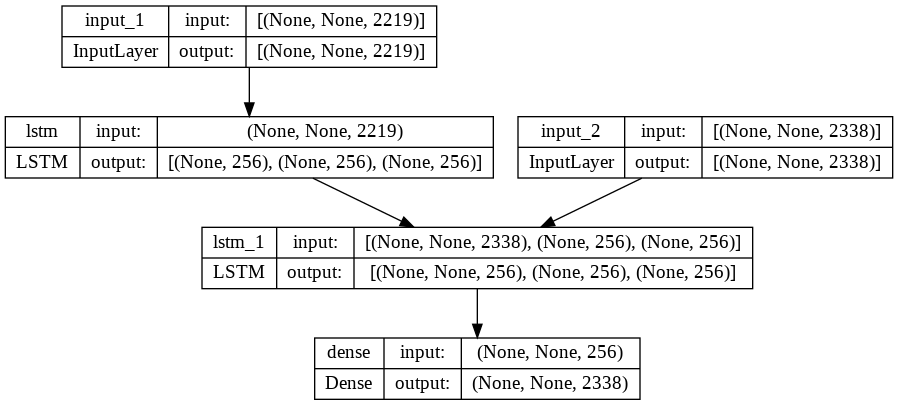

In [77]:
from keras.utils.vis_utils import plot_model
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [ ]:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')#Training

history1=training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)

training_model.save('training_model.h5')

Epoch 1/100
16/16 [==============================] - 62s 4s/step - loss: 0.7127 - accuracy: 0.0268 - val_loss: 0.6255 - val_accuracy: 0.0145
Epoch 2/100
13/16 [=======================>......] - ETA: 9s - loss: 0.6898 - accuracy: 0.0146 

In [ ]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predictions

In [ ]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [ ]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
          
          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
          
          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
          
          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [ ]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. AMA!\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
  
  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()

## Demo

In [ ]:
chatbot.start_chat()